# 🧠 OASIS – Preprocesamiento y Feature Engineering (Cortes Coronales)

Este notebook implementa el pipeline de preprocesamiento y extracción de características para detectar
Alzheimer en etapas tempranas a partir de cortes coronales del dataset OASIS.

## Contenido
- Normalización de intensidad por imagen (z-score sobre voxeles no cero).
- Recorte a *brain bounding box* y resize a **224×224**.
- Construcción de 3 canales: **original normalizada**, **Sobel (bordes)** y **diff vs plantilla CN**.
- Feature engineering de imágenes:
  - Grilla 16×16: mean y std por celda + selección de TOP-20 celdas más discriminativas.
  - Proxies anatómicos: `brain_fraction`, `central_peripheral_ratio`, `average_width`.
  - Edge features: `edge_energy` global + `edge_central` (ROI central).
  - Distancia a plantilla CN (L2 global y por ROI central).
  - Texturas (GLCM + LBP) en ROI temporal / medial aproximada.
- Exportación de un dataset tabular (`features_oasis_coronal.csv`) listo para modelos de ML.


## 0. Imports y configuración de rutas

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
from scipy import ndimage
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern
import pandas as pd
import seaborn as sns

BASE_DIR = r"C:\\Users\\mmera\\OneDrive\\Escritorio\\ProyectoMineria\\proyectoMineria"
IMG_DIR = os.path.join(BASE_DIR, 'data', 'processed', 'OASIS_2D')  # CN / MCI / AD

classes = ['CN', 'MCI', 'AD']
paths = {c: sorted(glob(os.path.join(IMG_DIR, c, '*.png'))) for c in classes}

for c in classes:
    print(f"{c}: {len(paths[c])} imágenes encontradas")


CN: 350 imágenes encontradas
MCI: 198 imágenes encontradas
AD: 48 imágenes encontradas


## 1. Plantilla promedio CN
Calculamos una imagen plantilla promedio para la clase CN. Esta plantilla se usará
para construir el canal `diff_vs_mean_CN` y para las distancias L2.

Shape CN raw: (350, 256, 128)


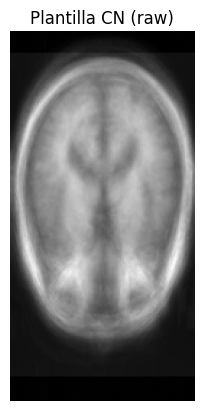

In [2]:
def load_gray(path):
    return np.array(Image.open(path).convert('L'), dtype=np.float32)

cn_imgs = [load_gray(p) for p in paths['CN']]
cn_imgs = np.stack(cn_imgs, axis=0) if len(cn_imgs) > 0 else None
print('Shape CN raw:', None if cn_imgs is None else cn_imgs.shape)

mean_CN_raw = cn_imgs.mean(axis=0)
plt.imshow(mean_CN_raw, cmap='gray'); plt.title('Plantilla CN (raw)'); plt.axis('off'); plt.show()


## 2. Funciones de preprocesamiento
Implementamos:
- `zscore_nonzero`: normalización z-score sobre voxeles > 0.
- `crop_brain`: recorte a bounding box del cerebro.
- `resize224`: reescalado a 224×224.
- `sobel_edges`: mapa de bordes.
- `prepare_three_channels`: construye los 3 canales propuestos.

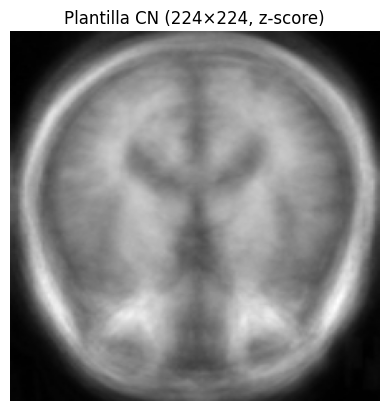

In [3]:
def zscore_nonzero(img: np.ndarray) -> np.ndarray:
    """Normaliza la imagen usando z-score sobre voxeles no cero."""
    mask = img > 0
    if not np.any(mask):
        return img.astype(np.float32)
    vals = img[mask]
    mu = vals.mean()
    sigma = vals.std() + 1e-6
    img_z = (img - mu) / sigma
    return img_z.astype(np.float32)

def crop_brain(img: np.ndarray) -> np.ndarray:
    """Recorta al bounding box de voxeles > 0. Si no hay, regresa la imagen original."""
    mask = img > 0
    if not np.any(mask):
        return img
    ys, xs = np.where(mask)
    y_min, y_max = ys.min(), ys.max()
    x_min, x_max = xs.min(), xs.max()
    return img[y_min:y_max+1, x_min:x_max+1]

def resize224(img: np.ndarray) -> np.ndarray:
    """Reescala a 224×224 usando bilinear."""
    pil = Image.fromarray(img.astype(np.float32))
    pil_resized = pil.resize((224, 224), Image.BILINEAR)
    return np.array(pil_resized, dtype=np.float32)

def sobel_edges(img: np.ndarray) -> np.ndarray:
    sx = ndimage.sobel(img, axis=0, mode='reflect')
    sy = ndimage.sobel(img, axis=1, mode='reflect')
    edges = np.hypot(sx, sy)
    return edges.astype(np.float32)

# Preparamos también la plantilla CN ya normalizada y reescalada
mean_CN_z = zscore_nonzero(mean_CN_raw)
mean_CN_crop = crop_brain(mean_CN_z)
mean_CN_224 = resize224(mean_CN_crop)

plt.imshow(mean_CN_224, cmap='gray'); plt.title('Plantilla CN (224×224, z-score)'); plt.axis('off'); plt.show()

def prepare_three_channels(img_raw: np.ndarray) -> np.ndarray:
    """Aplica z-score, recorte, resize y genera 3 canales: original, sobel, diff_vs_mean_CN."""
    img_z = zscore_nonzero(img_raw)
    img_crop = crop_brain(img_z)
    img_224 = resize224(img_crop)
    edges = sobel_edges(img_224)
    diff_cn = img_224 - mean_CN_224
    # Normalizamos Sobel y diff_cn a rangos comparables
    def norm_channel(ch):
        ch = ch - ch.mean()
        ch_std = ch.std() + 1e-6
        return ch / ch_std
    edges_n = norm_channel(edges)
    diff_n = norm_channel(diff_cn)
    stacked = np.stack([img_224, edges_n, diff_n], axis=-1)  # (224, 224, 3)
    return stacked


### 2.1. Ejemplo visual de los 3 canales

Ejemplo: C:\\Users\\mmera\\OneDrive\\Escritorio\\ProyectoMineria\\proyectoMineria\data\processed\OASIS_2D\CN\OAS2_0100_MR1_mpr-1.nifti_coronal.png


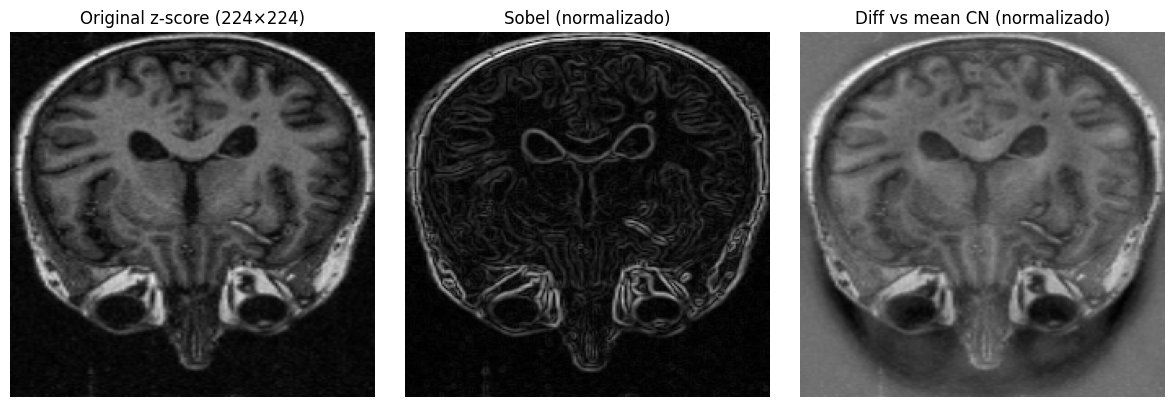

In [4]:
sample_path = paths['CN'][0] if len(paths['CN'])>0 else None
print('Ejemplo:', sample_path)
sample_raw = load_gray(sample_path)
sample_3ch = prepare_three_channels(sample_raw)

fig, axes = plt.subplots(1, 3, figsize=(12,4))
titles = ['Original z-score (224×224)', 'Sobel (normalizado)', 'Diff vs mean CN (normalizado)']
for i in range(3):
    axes[i].imshow(sample_3ch[:,:,i], cmap='gray')
    axes[i].set_title(titles[i])
    axes[i].axis('off')
plt.tight_layout(); plt.show()


## 3. Feature Engineering sobre imágenes
Definimos funciones para extraer características numéricas a partir de la imagen preprocesada (canal original 224×224).

In [5]:
GRID_SIZE = 16

def grid_features(img: np.ndarray, G: int = GRID_SIZE) -> np.ndarray:
    """Imagen (H,W) → concatena mean y std por celda de una grilla G×G."""
    H, W = img.shape
    h, w = H // G, W // G
    feats = []
    for i in range(G):
        for j in range(G):
            patch = img[i*h:(i+1)*h, j*w:(j+1)*w]
            if patch.size == 0:
                m = 0.0; s = 0.0
            else:
                m = patch.mean(); s = patch.std()
            feats.extend([m, s])
    return np.array(feats, dtype=np.float32)

def brain_fraction(img: np.ndarray) -> float:
    return float(np.mean(img > 0))

def central_peripheral_ratio(img: np.ndarray) -> float:
    H, W = img.shape
    cy1, cy2 = H//4, 3*H//4
    cx1, cx2 = W//4, 3*W//4
    central = img[cy1:cy2, cx1:cx2]
    peripheral = img.copy()
    peripheral[cy1:cy2, cx1:cx2] = 0
    cen_mean = central[central>0].mean() if np.any(central>0) else 0.0
    per_mask = peripheral > 0
    per_mean = peripheral[per_mask].mean() if np.any(per_mask) else 1e-6
    return float(cen_mean / (per_mean + 1e-6))

def average_width(img: np.ndarray) -> float:
    widths = []
    for row in img:
        xs = np.where(row > 0)[0]
        if len(xs) > 0:
            widths.append(xs.max() - xs.min())
    return float(np.mean(widths)) if len(widths) > 0 else 0.0

def edge_energy(edge_img: np.ndarray) -> float:
    return float(np.mean(edge_img**2))

def edge_central(edge_img: np.ndarray) -> float:
    H, W = edge_img.shape
    cy1, cy2 = H//4, 3*H//4
    cx1, cx2 = W//4, 3*W//4
    central = edge_img[cy1:cy2, cx1:cx2]
    return float(central.mean())

def distance_cn(img: np.ndarray, mean_cn: np.ndarray) -> float:
    diff = img - mean_cn
    return float(np.linalg.norm(diff.ravel(), ord=2))

def distance_cn_central(img: np.ndarray, mean_cn: np.ndarray) -> float:
    H, W = img.shape
    cy1, cy2 = H//4, 3*H//4
    cx1, cx2 = W//4, 3*W//4
    cen1 = img[cy1:cy2, cx1:cx2]
    cen2 = mean_cn[cy1:cy2, cx1:cx2]
    diff = cen1 - cen2
    return float(np.linalg.norm(diff.ravel(), ord=2))

def texture_features(img: np.ndarray) -> np.ndarray:
    """Texturas GLCM + LBP en una ROI central aproximada."""
    H, W = img.shape
    cy1, cy2 = H//4, 3*H//4
    cx1, cx2 = W//4, 3*W//4
    roi = img[cy1:cy2, cx1:cx2]
    # Normalizar a 0-255
    if roi.max() > roi.min():
        roi_norm = (roi - roi.min()) / (roi.max() - roi.min())
    else:
        roi_norm = roi - roi.min()
    roi_u8 = (roi_norm * 255).astype(np.uint8)

    glcm = graycomatrix(roi_u8, [1], [0], 256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0,0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0,0]
    correlation = graycoprops(glcm, 'correlation')[0,0]

    lbp = local_binary_pattern(roi_u8, P=8, R=1, method='uniform')
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=10, range=(0, 10), density=True)

    feats = np.concatenate([[contrast, homogeneity, correlation], lbp_hist])
    return feats.astype(np.float32)


### 3.1. Función maestra de extracción de features por imagen

In [6]:
def extract_features_for_image(img_raw: np.ndarray) -> (np.ndarray, np.ndarray):
    """Recibe una imagen raw (2D) y regresa:
    - img_224 (canal original z-score, 224×224)
    - feature vector 1D
    """
    img_z = zscore_nonzero(img_raw)
    img_crop = crop_brain(img_z)
    img_224 = resize224(img_crop)
    # Canal original
    base = img_224
    # Features de grilla
    grid_feats = grid_features(base)
    # Proxies anatómicos
    bf = brain_fraction(base)
    cpr = central_peripheral_ratio(base)
    aw = average_width(base)
    # Edge features
    edges = sobel_edges(base)
    ee = edge_energy(edges)
    ec = edge_central(edges)
    # Distancias a CN
    dcn = distance_cn(base, mean_CN_224)
    dcn_c = distance_cn_central(base, mean_CN_224)
    # Texturas
    tex = texture_features(base)
    # Concatenar todo
    feats = np.concatenate([
        grid_feats,
        np.array([bf, cpr, aw, ee, ec, dcn, dcn_c], dtype=np.float32),
        tex
    ])
    return base, feats

# Prueba rápida
base_example, feats_example = extract_features_for_image(sample_raw)
print('Imagen base shape:', base_example.shape)
print('Vector de features shape:', feats_example.shape)


Imagen base shape: (224, 224)
Vector de features shape: (532,)


## 4. Extracción de features para todo el dataset
Vamos a recorrer todas las imágenes de CN, MCI y AD, aplicar el preprocesamiento y extraer
las características numéricas en un `DataFrame`.

In [7]:
records = []

for label in classes:
    for p in paths[label]:
        img_raw = load_gray(p)
        base_img, feats = extract_features_for_image(img_raw)
        rec = {
            'filepath': os.path.relpath(p, BASE_DIR),
            'label': label
        }
        # Expand features into columns f_0, f_1, ...
        for i, val in enumerate(feats):
            rec[f'f_{i}'] = float(val)
        records.append(rec)

df_feats = pd.DataFrame.from_records(records)
print(df_feats.shape)
df_feats.head()


(596, 534)


,filepath,label,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,...,f_522,f_523,f_524,f_525,f_526,f_527,f_528,f_529,f_530,f_531
0,data\processed\OASIS_2D\CN\OAS2_0100_MR1_mpr-1...,CN,-0.941088,0.078861,-0.938237,0.088586,-0.946446,0.083849,-0.603710,0.709252,...,0.038744,0.070073,0.071110,0.140306,0.244898,0.148996,0.075574,0.063377,0.053890,0.093033
1,data\processed\OASIS_2D\CN\OAS2_0100_MR1_mpr-2...,CN,-0.928589,0.075608,-0.931318,0.076729,-0.940304,0.083803,-0.814452,0.284949,...,0.037867,0.070312,0.070791,0.141422,0.245057,0.155214,0.077886,0.063297,0.050462,0.087691
2,data\processed\OASIS_2D\CN\OAS2_0100_MR1_mpr-3...,CN,-0.939405,0.068105,-0.947817,0.066485,-0.923883,0.075591,-0.817656,0.268726,...,0.036193,0.068559,0.067602,0.141821,0.260204,0.158084,0.077168,0.059550,0.047034,0.083785
3,data\processed\OASIS_2D\CN\OAS2_0100_MR1_mpr-4...,CN,-0.927857,0.074659,-0.947224,0.067976,-0.947018,0.063306,-0.855170,0.246717,...,0.039222,0.067841,0.067363,0.139748,0.251355,0.156808,0.077647,0.062500,0.050064,0.087452
4,data\processed\OASIS_2D\CN\OAS2_0100_MR2_mpr-1...,CN,-1.010073,0.070229,-0.997820,0.069439,-0.987197,0.091159,-0.880045,0.195101,...,0.037229,0.063217,0.069037,0.149075,0.265147,0.163584,0.076929,0.053890,0.041853,0.080038


## 5. Selección de TOP-20 celdas de grilla más discriminativas
Usamos las features de grilla (mean y std por celda) para identificar qué regiones cambian más
entre CN y AD. Nos quedamos con las 20 celdas con mayor diferencia absoluta en la media.

🧠 Por qué las features de la grilla (mean/std por celda) son las más discriminativas

## 1️⃣ ¿Qué representan estas features?

Cada **celda de la grilla 16×16** representa una **región espacial fija** del corte coronal (por ejemplo, una ventana 14×14 px dentro de la imagen reescalada a 224×224).

Para cada celda calculamos:

* **mean** → cuánta “intensidad promedio” hay en esa parte del cerebro
* **std** → cuánta variabilidad local tiene la estructura (cortes, bordes, textura)

En total:

* 16×16 = 256 celdas
* Cada celda aporta mean + std → 512 features (f_0…f_511)

Estas features capturan **información anatómica localizada**.

---

## 2️⃣ ¿Por qué se comparan CN vs AD?

```python
cn_grid = df_feats[df_feats['label']=='CN'][grid_cols].mean(axis=0)
ad_grid = df_feats[df_feats['label']=='AD'][grid_cols].mean(axis=0)
diff = (ad_grid - cn_grid).abs()
```

Esto calcula:

* **Promedio de cada celda para todos los sujetos normales (CN)**
* **Promedio de la misma celda en sujetos con Alzheimer (AD)**
* **Diferencia absoluta entre ambas**

Luego seleccionamos las 20 celdas donde esa diferencia es mayor:

```python
top20_idx = diff.sort_values(ascending=False).index[:20]
```

Estas son las regiones que **más cambian entre CN y AD**.

---

## 3️⃣ ¿Por qué esas celdas son las más discriminativas?

✔ Razón 1: El Alzheimer produce atrofia **regional**, no global

Tu EDA previa ya lo mostraba (coronal plots y mapas por secciones):
Las mayores diferencias entre CN y AD aparecen en:

* **Lóbulos temporales mediales**
* **Hipocampo**
* **Región parahipocampal**
* **Alrededor de los ventrículos laterales**

Estas áreas se encuentran en **partes muy específicas del corte coronal**.

Es decir:
✔ no cambia toda la imagen por igual,
✘ no cambia la media global,
✔ cambian regiones anatómicas concretas.

Por eso, los valores **mean** de esas celdas bajan en AD (menos masa, más LCR → menor intensidad).

---

✔ Razón 2: Los ventrículos se expanden en AD → aumentan intensidades bajas

En tus imágenes:

* CN → ventrículos normales
* AD → ventrículos más grandes (más negro / intensidades bajas en MRI T1)

Esto causa:

* **celda(s) cerca del centro → mean más bajo en AD**
* **std más alto** (mezcla de tejido y LCR)

La diferencia CN–AD en esas celdas es muy marcada → alta discriminación.

---

✔ Razón 3: El hipocampo se reduce → bordes menos definidos

En las regiones cerca del hipocampo:

* La intensidad media baja.
* La desviación estándar puede aumentar (más variabilidad por atrofia).

El grid captura exactamente esas regiones porque mantiene la estructura espacial.

---

✔ Razón 4: Mean/Std son estadísticas muy sensibles a atrofias regionales

La atrofia altera:

* tamaño,
* textura,
* presencia de LCR,
* densidad de sustancia gris/ blanca.

Cada una de estas cosas afecta directamente:

* mean → baja intensidad
* std → diferencias de contorno o mezcla de tejidos

y las celdas de la grilla lo capturan con precisión milimétrica.

---

## 4️⃣ ¿Por qué no fueron más discriminativas las features globales?

Tus EDA mostraron:

* mean global similar entre CN, MCI, AD
* std global muy similar
* histograma global muy solapado

¿Por qué?

Porque **el cerebro completo sigue ocupando la mayor parte del corte**, incluso con atrofia.
La expansión de ventrículos y la pérdida de hipocampo afectan pequeñas zonas, que se pierden al promediar toda la imagen.

La grilla (especialmente 16×16) **preserva la señal regional** → lo que realmente distingue AD temprano.

---

## 5️⃣ Conclusión

Las features de la grilla son las más discriminativas porque:

🧩 1. Capturan **información espacial localizada**, crítica para Alzheimer.

🧠 2. Detectan atrofia en regiones anatómicas clave (hipocampo, temporal medial, ventrículos).

📉 3. Mean/Std cambian de forma significativa en esas regiones.

🎯 4. La atrofia no es global → los features globales pierden información.

🚀 5. La grilla funciona como un “atlas aproximado” sin segmentación.

En otras palabras:

**El Alzheimer deja patrones espaciales, no globales.
La grilla detecta esos patrones.**


In [8]:
# Localizamos cuáles columnas del DataFrame corresponden a la grilla.
# Por construcción, grid_features va primero, así que f_0 .. f_{2*G^2-1} son mean/std por celda.
G = GRID_SIZE
num_grid_feats = 2 * G * G
grid_cols = [f'f_{i}' for i in range(num_grid_feats)]

cn_grid = df_feats[df_feats['label']=='CN'][grid_cols].mean(axis=0)
ad_grid = df_feats[df_feats['label']=='AD'][grid_cols].mean(axis=0)
diff = (ad_grid - cn_grid).abs()

top20_idx = diff.sort_values(ascending=False).index[:20]
print('TOP-20 columnas más discriminativas (grilla):')
print(top20_idx.tolist())


TOP-20 columnas más discriminativas (grilla):
['f_458', 'f_92', 'f_126', 'f_460', 'f_348', 'f_470', 'f_290', 'f_442', 'f_372', 'f_312', 'f_440', 'f_388', 'f_324', 'f_284', 'f_280', 'f_370', 'f_472', 'f_258', 'f_410', 'f_434']


### 5.1. Sub-DataFrame sólo con TOP-20 features de grilla
Podemos crear una versión reducida del dataset que use únicamente estas features de grilla +
las demás features globales/proxies/texturas.

In [9]:
other_cols = [c for c in df_feats.columns if c.startswith('f_') and c not in top20_idx]
# Si quisiéramos un dataset sólo con top20 de grilla + resto, podemos reordenar
ordered_cols = ['filepath', 'label'] + list(top20_idx) + other_cols
df_feats_reordered = df_feats[ordered_cols]
df_feats_reordered.head()


,filepath,label,f_458,f_92,f_126,f_460,f_348,f_470,f_290,f_442,...,f_522,f_523,f_524,f_525,f_526,f_527,f_528,f_529,f_530,f_531
0,data\processed\OASIS_2D\CN\OAS2_0100_MR1_mpr-1...,CN,-0.937640,1.070091,0.720543,-0.895420,1.653419,-0.897521,1.079860,-0.960886,...,0.038744,0.070073,0.071110,0.140306,0.244898,0.148996,0.075574,0.063377,0.053890,0.093033
1,data\processed\OASIS_2D\CN\OAS2_0100_MR1_mpr-2...,CN,-0.960011,1.025180,0.718458,-0.902658,1.920019,-0.919848,0.683486,-0.932435,...,0.037867,0.070312,0.070791,0.141422,0.245057,0.155214,0.077886,0.063297,0.050462,0.087691
2,data\processed\OASIS_2D\CN\OAS2_0100_MR1_mpr-3...,CN,-0.953359,0.996083,0.638557,-0.908893,2.209755,-0.931610,0.704689,-0.941208,...,0.036193,0.068559,0.067602,0.141821,0.260204,0.158084,0.077168,0.059550,0.047034,0.083785
3,data\processed\OASIS_2D\CN\OAS2_0100_MR1_mpr-4...,CN,-0.944212,1.060999,0.666464,-0.886607,2.202596,-0.910619,0.767076,-0.942668,...,0.039222,0.067841,0.067363,0.139748,0.251355,0.156808,0.077647,0.062500,0.050064,0.087452
4,data\processed\OASIS_2D\CN\OAS2_0100_MR2_mpr-1...,CN,0.040031,-0.461131,-0.740699,-0.414122,0.301473,0.590794,-0.343900,0.365542,...,0.037229,0.063217,0.069037,0.149075,0.265147,0.163584,0.076929,0.053890,0.041853,0.080038


## 6. Exportar features a CSV
Guardamos el dataset de características para su uso posterior en modelos de clasificación.

In [10]:
OUTPUT_DIR = os.path.join(BASE_DIR, 'data', 'processed')
os.makedirs(OUTPUT_DIR, exist_ok=True)
csv_path = os.path.join(OUTPUT_DIR, 'features_oasis_coronal.csv')
df_feats_reordered.to_csv(csv_path, index=False)
print('CSV guardado en:', csv_path)


CSV guardado en: C:\\Users\\mmera\\OneDrive\\Escritorio\\ProyectoMineria\\proyectoMineria\data\processed\features_oasis_coronal.csv


# 🔥 HEATMAP DE DIFERENCIAS CN–AD EN LA GRILLA 16×16

In [ ]:
import seaborn as sns

CSV_PATH = r"C:\Users\mmera\OneDrive\Escritorio\ProyectoMineria\proyectoMineria\data\processed\features_oasis_coronal.csv"
df = pd.read_csv(CSV_PATH)

# -----------------------------
# Seleccionar únicamente columnas de grilla
# grid_features produce 2*(G*G) columnas
# → mean y std por celda
# Aquí G = 16 → 512 columnas
# -----------------------------
G = 16
num_grid_feats = 2 * G * G
grid_cols = [f"f_{i}" for i in range(num_grid_feats)]

# Agrupar por clase
cn_mean = df[df["label"] == "CN"][grid_cols].mean(axis=0)
ad_mean = df[df["label"] == "AD"][grid_cols].mean(axis=0)

# Diferencias absolutas CN–AD
diff = (ad_mean - cn_mean).abs()

top20 = diff.sort_values(ascending=False).index[:20]
print("TOP-20 features más discriminativas:")
print(top20.tolist())

mean_indices = [i for i in range(num_grid_feats) if i % 2 == 0]
diff_mean = diff[[f"f_{i}" for i in mean_indices]]

# Crear matriz 16×16
heatmap_matrix = diff_mean.values.reshape(G, G)

# -----------------------------
# Plot del heatmap
# -----------------------------
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_matrix, cmap="inferno", annot=False, cbar=True)
plt.title("Heatmap de Diferencias CN–AD (Mean por Celda 16×16)")
plt.xlabel("Columna de grilla")
plt.ylabel("Fila de grilla")
plt.show()

# Heatmap con TOP-20 celdas marcadas
# Crear una matriz booleana para marcar top-20
mask_top20 = np.zeros((G, G))

# Convertir top20 a índices (mean only)
top20_mean_indices = [int(idx.replace("f_", "")) for idx in top20 if int(idx.replace("f_","")) % 2 == 0]

for idx in top20_mean_indices:
    cell = idx // 2  # dividir entre 2 porque mean ocupa índices pares
    r = cell // G
    c = cell % G
    mask_top20[r, c] = 1

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_matrix, cmap="inferno", cbar=True)

# Overlay de las celdas top-20
for r in range(G):
    for c in range(G):
        if mask_top20[r, c] == 1:
            plt.text(c + 0.5, r + 0.5, "★",
                     ha="center", va="center", color="cyan", fontsize=18)

plt.title("Heatmap CN–AD con TOP-20 celdas más discriminativas (★)")
plt.xlabel("Columna de grilla")
plt.ylabel("Fila de grilla")
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'data/processed/features_oasis_coronal.csv'